# Experiment w clustering for online word detection

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.metrics import adjusted_rand_score

from xournalpp_htr.training.io import load_list_of_bboxes

## Experiment structure

### Hypothesis

One can find an algorithm that segments strokes into words using my handwriting.

Side note: This is useful b/c I can then use [OnlineHTR](https://github.com/PellelNitram/OnlineHTR) to transcribe the words.

### Notebook structure

1. Load data, incl ground truth.
2. Pre-compute a set of features. Later, feature engineering might be added.
3. Iterate over a few algorithms and measure their performance using the ground truth.

Alternative addition later on: Manually remove strokes that're too long (in distribution sense) or too straight. That is another step because it will require a dataset with such strokes that don't belong to words.

In [3]:
## Settings

OUTPUT_PATH = Path("experiment_results")
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

## Helper functions

In [37]:
import matplotlib as mpl


def plot_clustered_document(
    a_ground_truth: mpl.axis.Axis,
    a_predicted: mpl.axis.Axis,
    clustering,
    annotated_bboxes,
    DPI,
    df_train: pd.DataFrame,
    a_predicted_title: str,
) -> None:
    """Plots clustered document into axes."""

    # ===================
    # Ground truth figure
    # ===================

    # I replicated this from below - TODO: Follow DIY and consolidate

    a_ground_truth.set_aspect("equal")
    a_ground_truth.set_xlabel("x")
    a_ground_truth.set_ylabel("y")

    for i_bbox in range(len(annotated_bboxes["bboxes"])):
        bbox = annotated_bboxes["bboxes"][i_bbox]

        # Draw bbox
        xy = (
            min([bbox["point_1_x"], bbox["point_2_x"]]) / DPI,
            min([-bbox["point_1_y"], -bbox["point_2_y"]])
            / DPI,  # TODO: This messing around w/ y coord sign is annoying
        )
        dx = np.abs(bbox["point_1_x"] - bbox["point_2_x"]) / DPI
        dy = np.abs(bbox["point_1_y"] - bbox["point_2_y"]) / DPI
        a_ground_truth.add_patch(
            patches.Rectangle(xy, dx, dy, linewidth=1, edgecolor="r", facecolor="none")
        )

        # Draw label
        a_ground_truth.text(x=xy[0], y=xy[1] + dy, s=bbox["text"], c="red")

        for bbox_stroke in bbox["bbox_strokes"]:
            x = bbox_stroke["x"] / DPI
            y = bbox_stroke["y"] / DPI
            a_ground_truth.scatter(x, -y, c="black", s=1)

    # ================
    # Predicted figure
    # ================

    a_predicted.set_aspect("equal")
    a_predicted.set_xlabel("x")
    a_predicted.set_ylabel("y")
    a_predicted.set_title(a_predicted_title)

    for i_cluster in np.unique(clustering.labels_):
        stroke_indices = np.where(clustering.labels_ == i_cluster)[0]

        print(i_cluster, stroke_indices)

        x_coords = []
        y_coords = []
        x_coords_mean = []
        y_coords_mean = []
        for stroke_index in stroke_indices:
            stroke_row = df_train.iloc[stroke_index]

            x_coords += stroke_row["x"].tolist()
            y_coords += stroke_row["y"].tolist()
            x_coords_mean.append(stroke_row["x_mean"])
            y_coords_mean.append(stroke_row["y_mean"])

        a_predicted.scatter(x_coords, y_coords, s=1)
        a_predicted.scatter(x_coords_mean, y_coords_mean, c="red", s=1)

## Load annotations

Previously, I loaded the data as `XournalppDocument` but that approach lacked ground truth data. Instead, I now load the annotated data, which comes with ground truth data.

In [4]:
annotated_bboxes = load_list_of_bboxes(
    "../tests/data/2024-10-13_minimal.annotations.json"
)

DPI = 72  # TODO: Add this to annotations!

# TODO: Maybe integrate `/DPI` into the x and y values? Maybe convert to cm?
# TODO: Add page dimensions, i.e.:
# - float(page.meta_data["width"]) / DPI,
# - float(page.meta_data["height"]) / DPI,

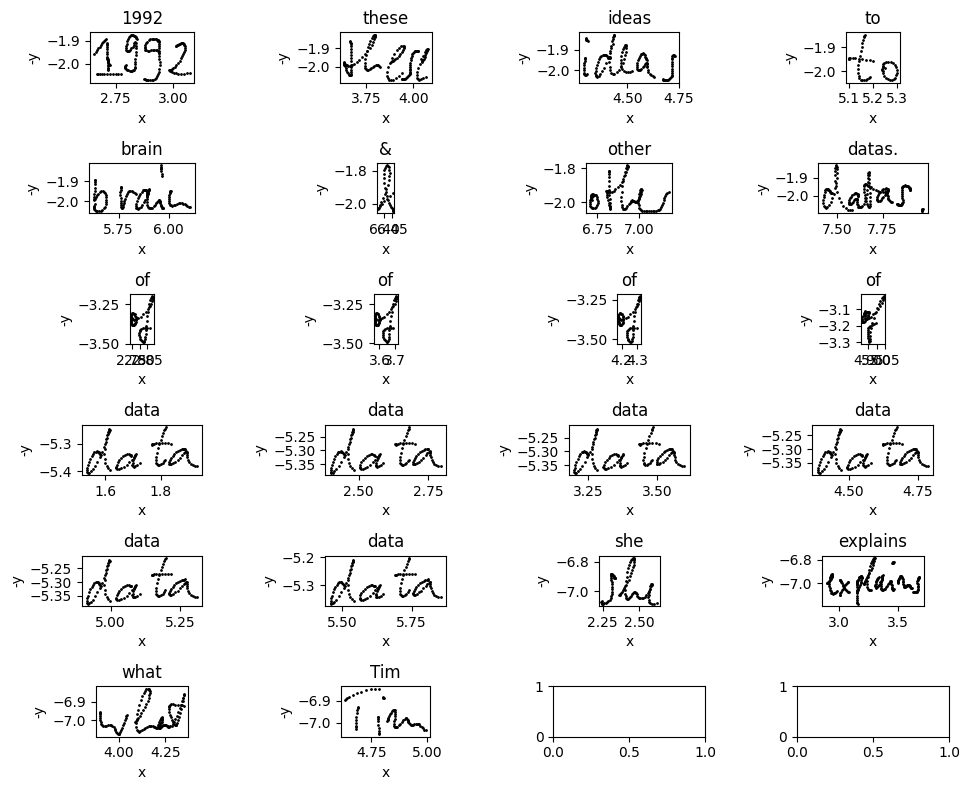

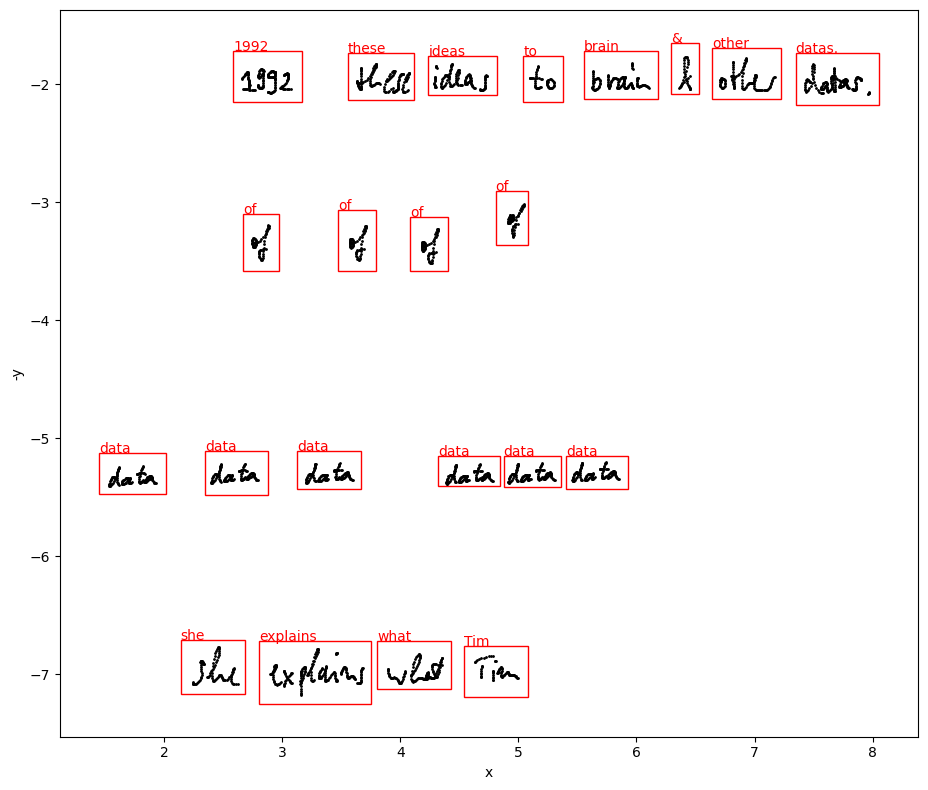

In [5]:
# ========
# Figure 1
# ========

length = len(annotated_bboxes["bboxes"])
nr_2 = 4
nr_1 = length // nr_2 + 1

fig, axes = plt.subplots(nrows=nr_1, ncols=nr_2, figsize=(10, 8))

for i_bbox in range(length):
    bbox = annotated_bboxes["bboxes"][i_bbox]

    a = axes.flatten()[i_bbox]

    a.set_aspect("equal")
    a.set_title(bbox["text"])
    a.set_xlabel("x")
    a.set_ylabel("-y")

    for bbox_stroke in bbox["bbox_strokes"]:
        x = bbox_stroke["x"] / DPI
        y = bbox_stroke["y"] / DPI
        a.scatter(x, -y, c="black", s=1)

plt.tight_layout()
plt.show()

# ========
# Figure 2
# ========

plt.figure(figsize=(10, 8))

a = plt.gca()
a.set_aspect("equal")
a.set_xlabel("x")
a.set_ylabel("-y")

for i_bbox in range(length):
    bbox = annotated_bboxes["bboxes"][i_bbox]

    # Draw bbox
    xy = (
        min([bbox["point_1_x"], bbox["point_2_x"]]) / DPI,
        min([-bbox["point_1_y"], -bbox["point_2_y"]])
        / DPI,  # TODO: This messing around w/ y coord sign is annoying
    )
    dx = np.abs(bbox["point_1_x"] - bbox["point_2_x"]) / DPI
    dy = np.abs(bbox["point_1_y"] - bbox["point_2_y"]) / DPI
    a.add_patch(
        patches.Rectangle(xy, dx, dy, linewidth=1, edgecolor="r", facecolor="none")
    )

    # Draw label
    a.text(x=xy[0], y=xy[1] + dy, s=bbox["text"], c="red")

    for bbox_stroke in bbox["bbox_strokes"]:
        x = bbox_stroke["x"] / DPI
        y = bbox_stroke["y"] / DPI
        a.scatter(x, -y, c="black", s=1)

plt.tight_layout()
plt.show()

Prepare list of all strokes w/ relevant meta information as ground truth. This variable serves as training data:

In [6]:
df_strokes_data = {
    "x": [],
    "y": [],
    "x_mean": [],
    "y_mean": [],
    "i_bbox": [],
    "text": [],
}

for i_bbox in range(len(annotated_bboxes["bboxes"])):
    bbox = annotated_bboxes["bboxes"][i_bbox]

    for bbox_stroke in bbox["bbox_strokes"]:
        x = +bbox_stroke["x"] / DPI
        y = -bbox_stroke["y"] / DPI

        df_strokes_data["x"].append(x)
        df_strokes_data["y"].append(y)
        df_strokes_data["x_mean"].append(np.mean(x))
        df_strokes_data["y_mean"].append(np.mean(y))
        df_strokes_data["i_bbox"].append(i_bbox)
        df_strokes_data["text"].append(bbox["text"])

df_train = pd.DataFrame.from_dict(df_strokes_data)

Plot the training data:

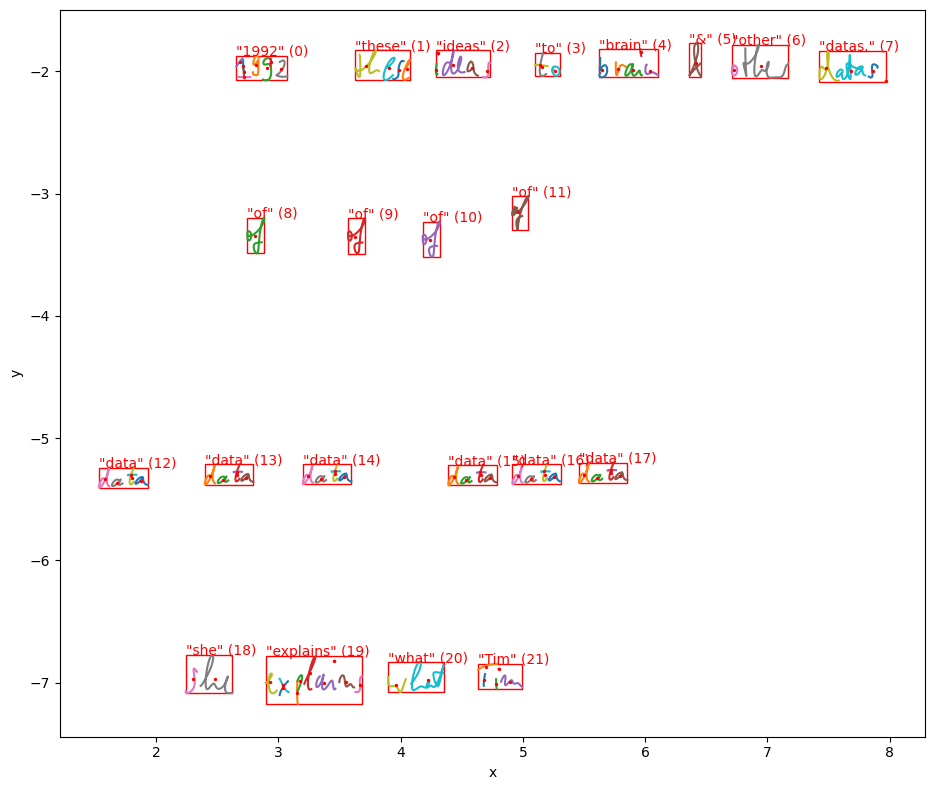

In [7]:
plt.figure(figsize=(10, 8))

a = plt.gca()
a.set_aspect("equal")
a.set_xlabel("x")
a.set_ylabel("y")

for (i_bbox, text), df_grouped in df_train.groupby(
    ["i_bbox", "text"],
):
    a.scatter(df_grouped["x_mean"], df_grouped["y_mean"], c="red", s=2, zorder=999)

    bottom_left_x = np.inf
    bottom_left_y = np.inf
    top_right_x = -np.inf
    top_right_y = -np.inf
    for _, row in df_grouped.iterrows():
        a.plot(row.x, row.y)  # , c=cmap(i_row/N))
        if row.x.min() < bottom_left_x:
            bottom_left_x = row.x.min()
        if row.y.min() < bottom_left_y:
            bottom_left_y = row.y.min()
        if row.x.max() > top_right_x:
            top_right_x = row.x.max()
        if row.y.max() > top_right_y:
            top_right_y = row.y.max()

    # Plot bounding box
    xy = (bottom_left_x, bottom_left_y)
    dx = top_right_x - bottom_left_x
    dy = top_right_y - bottom_left_y
    a.add_patch(
        patches.Rectangle(xy, dx, dy, linewidth=1, edgecolor="r", facecolor="none")
    )

    # Plot text
    a.text(x=bottom_left_x, y=top_right_y, s=f'"{text}" ({i_bbox})', c="red")


plt.tight_layout()
plt.show()

## Iterate over clustering algorithms

In [44]:
%%time

all_clusterings = [
    AgglomerativeClustering(
        n_clusters=22, distance_threshold=None
    ),  # I hard-code 22 b/c I counted that there're 22 clusters
    AgglomerativeClustering(n_clusters=10, distance_threshold=None),
    AgglomerativeClustering(
        n_clusters=None, distance_threshold=1e0
    ),  # One could maybe tune it by investigating nr of clusters over distance threshold; TODO: Distance threshold using distribution?!
    SpectralClustering(
        n_clusters=15,  # 21,
        affinity="nearest_neighbors",
    ),
    SpectralClustering(
        n_clusters=21,  # 21,
        affinity="nearest_neighbors",
    ),
    SpectralClustering(
        n_clusters=6,  # 21,
        affinity="nearest_neighbors",
    ),
]

all_clusterings += [DBSCAN(eps) for eps in np.logspace(-4, 1, 1000)]

results = {
    "index": [],
    "score": [],
}
for i_clustering, clustering in enumerate(all_clusterings):
    clustering.fit(df_train[["x_mean", "y_mean"]])

    score = adjusted_rand_score(df_train["i_bbox"], clustering.labels_)

    results["index"].append(i_clustering)
    results["score"].append(score)

    # Plotting
    fig, [a_ground_truth, a_predicted] = plt.subplots(1, 2, figsize=(10, 8))
    plot_clustered_document(
        a_ground_truth,
        a_predicted,
        clustering,
        annotated_bboxes,
        DPI,
        df_train,
        a_predicted_title=f"A-RAND={score}",
    )
    plt.savefig(OUTPUT_PATH / f"iClustering{i_clustering}.png")
    plt.close()

results = pd.DataFrame.from_dict(results)

/home/martin/anaconda3/envs/xournalpp_htr/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/martin/anaconda3/envs/xournalpp_htr/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/martin/anaconda3/envs/xournalpp_htr/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


CPU times: user 3.73 s, sys: 5.01 ms, total: 3.73 s
Wall time: 3.43 s


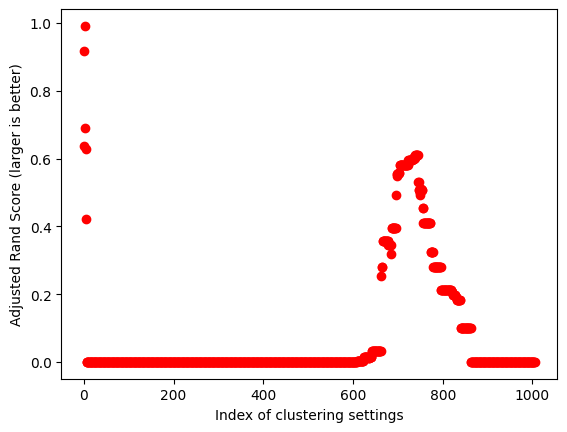

In [40]:
plt.figure()

plt.scatter(results["index"], results["score"], c="red")

plt.xlabel("Index of clustering settings")
plt.ylabel("Adjusted Rand Score (larger is better)")
plt.savefig("2024-10-18_clustering_experiments.png", dpi=200)

Learning: The peak at ~800 seems to classify rows of text. This should be fine w/ OnlineHTR!

Next, check if the clusters make sense:

Interestingly, the result is not too bad!


Next, investigate number of clusters against threshold:

In [ ]:
# N_CLUSTERS = None

# distance_thresholds = []
# number_of_clusters = []

# for DISTANCE_THRESHOLD in np.logspace(-4, 1, 1000):
#     clustering = AgglomerativeClustering(
#         n_clusters=N_CLUSTERS, distance_threshold=DISTANCE_THRESHOLD
#     ).fit(X)

#     distance_thresholds.append(DISTANCE_THRESHOLD)
#     number_of_clusters.append(np.unique(clustering.labels_).shape)

# plt.figure()
# plt.plot(distance_thresholds, number_of_clusters)
# plt.xlabel("distance_thresholds")
# plt.ylabel("number_of_clusters")
# plt.show()

^-- Unfortunately, one cannot see a clear sign of what distance threshold to pick. This is probably a function of the the content of the page (e.g. diagrams, written text height, etc).

Next, question: Is this approach robust against larger handwriting?

Next, plot the dendrogram, see [here](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py).

Next, try out DBSCAN! Also see [here](https://scikit-learn.org/stable/modules/clustering.html).

Also next, try out another document to play around with.

Question: Is my OnlineHTR model robust against rotated text?! Maybe one should rotate the text first?

Note: It is probably worth it to write a bit of infrastructure code to experiment more (and easier and easier to compare) with these clustering approaches.

Next: Feed these sequences to `OnlineHTR` or retrained `SimpleHTR` nmodel.

## Attemp 3: DBSCAN

In [ ]:
# plt.figure(
#     figsize=(
#         float(page.meta_data["width"]) / DPI,
#         float(page.meta_data["height"]) / DPI,
#     )
# )

# for i_cluster in np.unique(clustering.labels_):
#     stroke_indices = np.where(clustering.labels_ == i_cluster)[0]

#     print(i_cluster, stroke_indices)

#     x_coords = []
#     y_coords = []
#     x_coords_mean = []
#     y_coords_mean = []
#     for stroke_index in stroke_indices:
#         stroke = all_strokes[stroke_index]
#         x_coords += stroke["x"].tolist()
#         y_coords += stroke["y"].tolist()
#         x_coords_mean.append(stroke["x_mean"])
#         y_coords_mean.append(stroke["y_mean"])

#     if i_cluster == -1:
#         plt.scatter(x_coords, y_coords, s=1, alpha=1, c="fuchsia")
#     else:
#         plt.scatter(x_coords, y_coords, s=1)
#     plt.scatter(x_coords_mean, y_coords_mean, c="red", s=1)

# plt.gca().set_aspect("equal")
# plt.show()

The DBSCAN method seems to throw many of the words in the noisy class; this is probably worth investigating. Other than that, it seems to work OK-ish.

Interestingly, I think the biggest problem for the OnlineHTR model would be the different line positions based on the way it was trained. Hence, one could maybe put extra emphasis on clusters being on similar y values.

NEXT: Spectral clustering!

I have to say that I am unclear if a heuristic (i.e. a clustering algo w/ smartly chosen parameters) is really enough. Certainly for now, but a fully data-driven way would be better to accommodate different writers. This is probably relevant for a next iteration of the model.

## TODO:

- Good source for rand score: [see here](https://stats.stackexchange.com/questions/260229/comparing-a-clustering-algorithm-partition-to-a-ground-truth-one).
- After finding the best clustering, do apply OnlineHTR to check how it performs!
- To overcome the scale issue (i.e. everyone's handwriting scale is a wee bit different), one would need to use an approach that is based on 'nearest neighbours'. This works b/c one does not write on top of existing words.
    - also, one could weight the x direction more in definition of closeness/distance